In [1]:
#!/usr/bin/env pyhton3
# -*- coding 

from sklearn import datasets
from sklearn.model_selection import train_test_split
###-----------------
### Import Libraries
###-----------------
import os
import time
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
import gc

from sklearn.metrics import mean_squared_error,accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

import warnings
warnings.filterwarnings('ignore')
from utils.helper import fn_plot_tf_hist, fn_plot_confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [2]:
# Global variables
inpDir = './input' # Input Stored here
outDir = './ouput' # output Here
modelDir = './models'# to save Models
subDir = 'fashion_mnist' # sub dir by dataset
RANDOM_STATE = 24
np.random.RandomState(seed = RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)
#rng = np.random.default_rng(seed = RANDOM_STATE)
#N_SAMPLE = 1000
TEST_SIZE = 0.2 # 18147 - 56*256
ALPHA = 0.001 # learning rate
NOISE = 0.2 # Error
EPOCHS = 30
BATCH_SIZE = 32# default for tensorflow

PATIENCE = 10
LR_FACTOR = 0.1
LR_PATIENCE = 10

In [3]:
#set the plotting parameters
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 8),
          'axes.labelsize': 'large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'large',
          'ytick.labelsize':'large'
         }
    #'text.usetex':True,

plt.rcParams.update(params)
CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')


In [4]:
fileName = 'weatherHistory.csv'

data_df = pd.read_csv(os.path.join(inpDir, fileName))
data_df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


<Axes: xlabel='Formatted Date'>

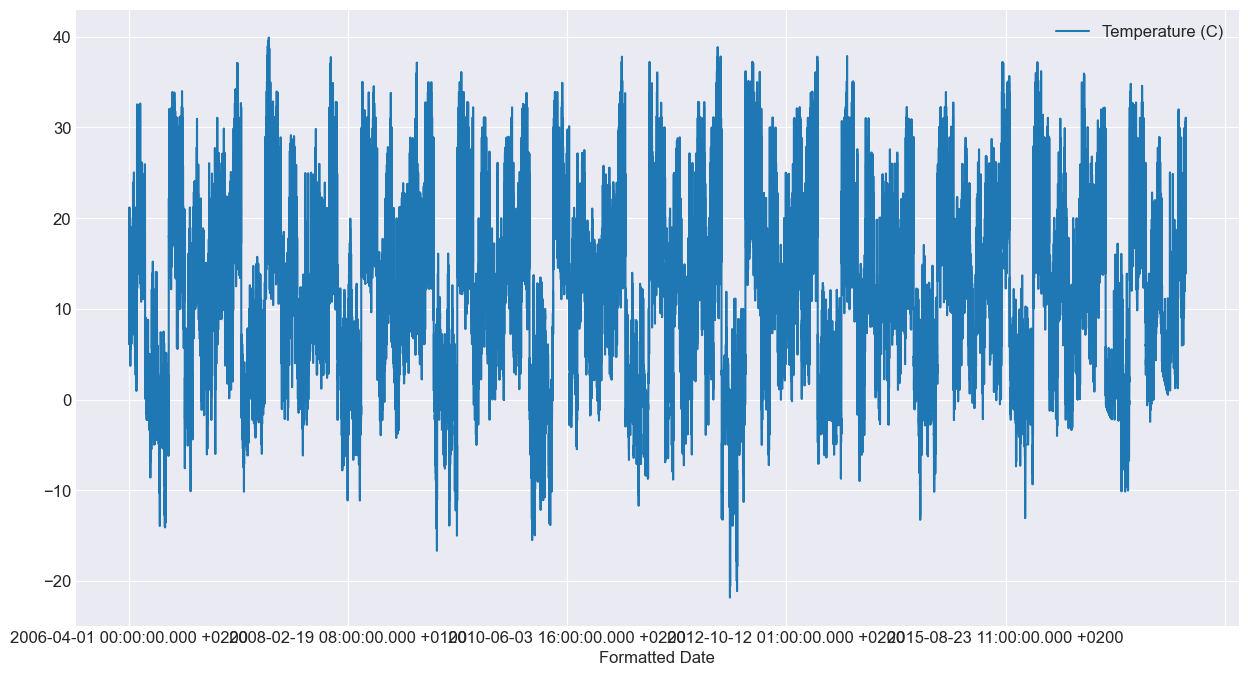

In [5]:
fig, ax = plt.subplots()
data_df.plot(x = 'Formatted Date', y = 'Temperature (C)', ax =ax)


In [6]:
data_df['datetime'] = pd.to_datetime(data_df['Formatted Date'], utc = True)

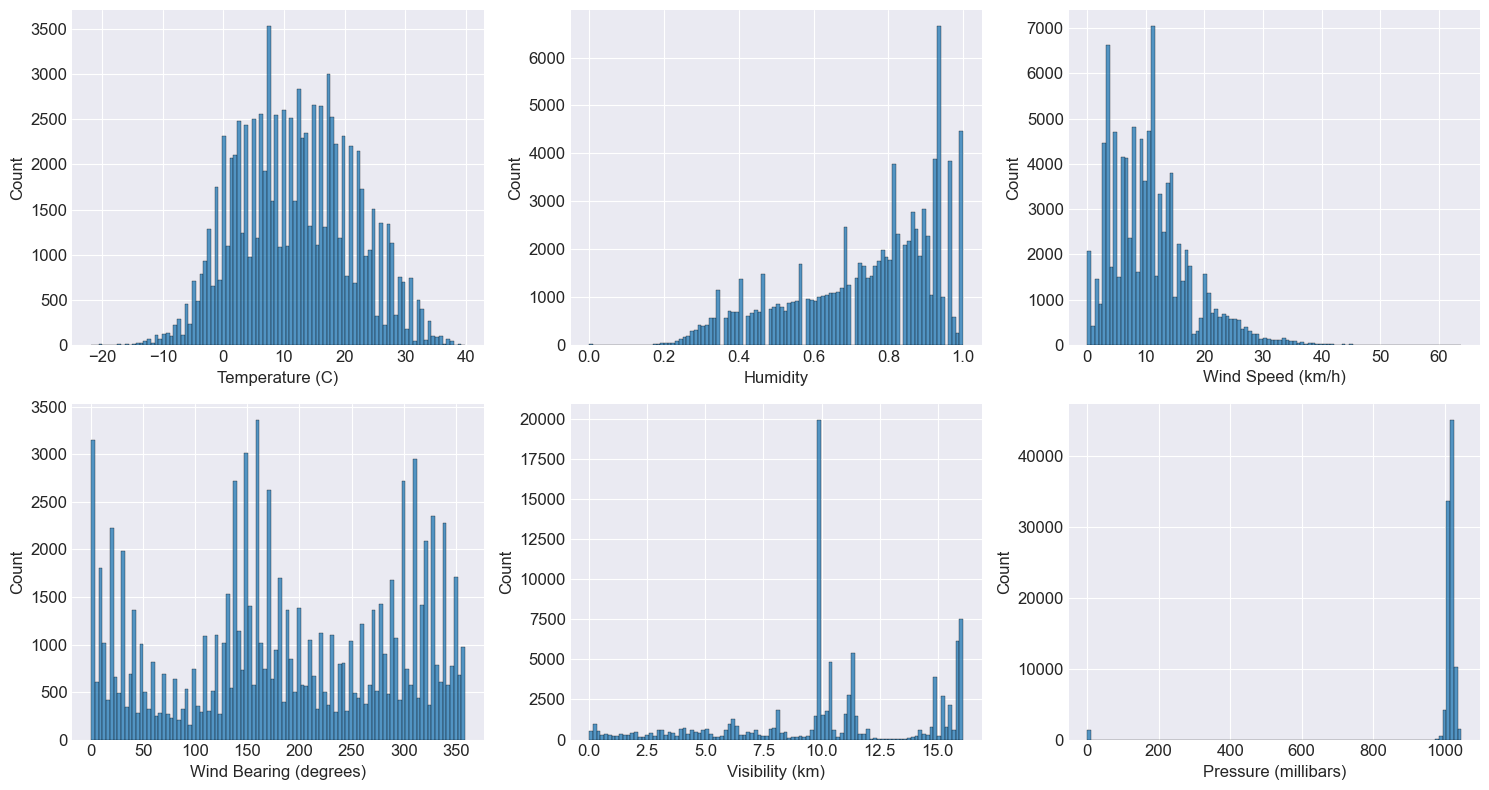

In [7]:
num_cols = ['Temperature (C)',
        'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Pressure (millibars)']

fig, axes = plt.subplots(2,3 ,figsize = (15,8))
nbin = 100
axes = axes.ravel()
for count,col in enumerate(num_cols):
    ax = axes[count]
    sns.histplot(data = data_df, x = col, ax = ax, bins = nbin)
plt.tight_layout()

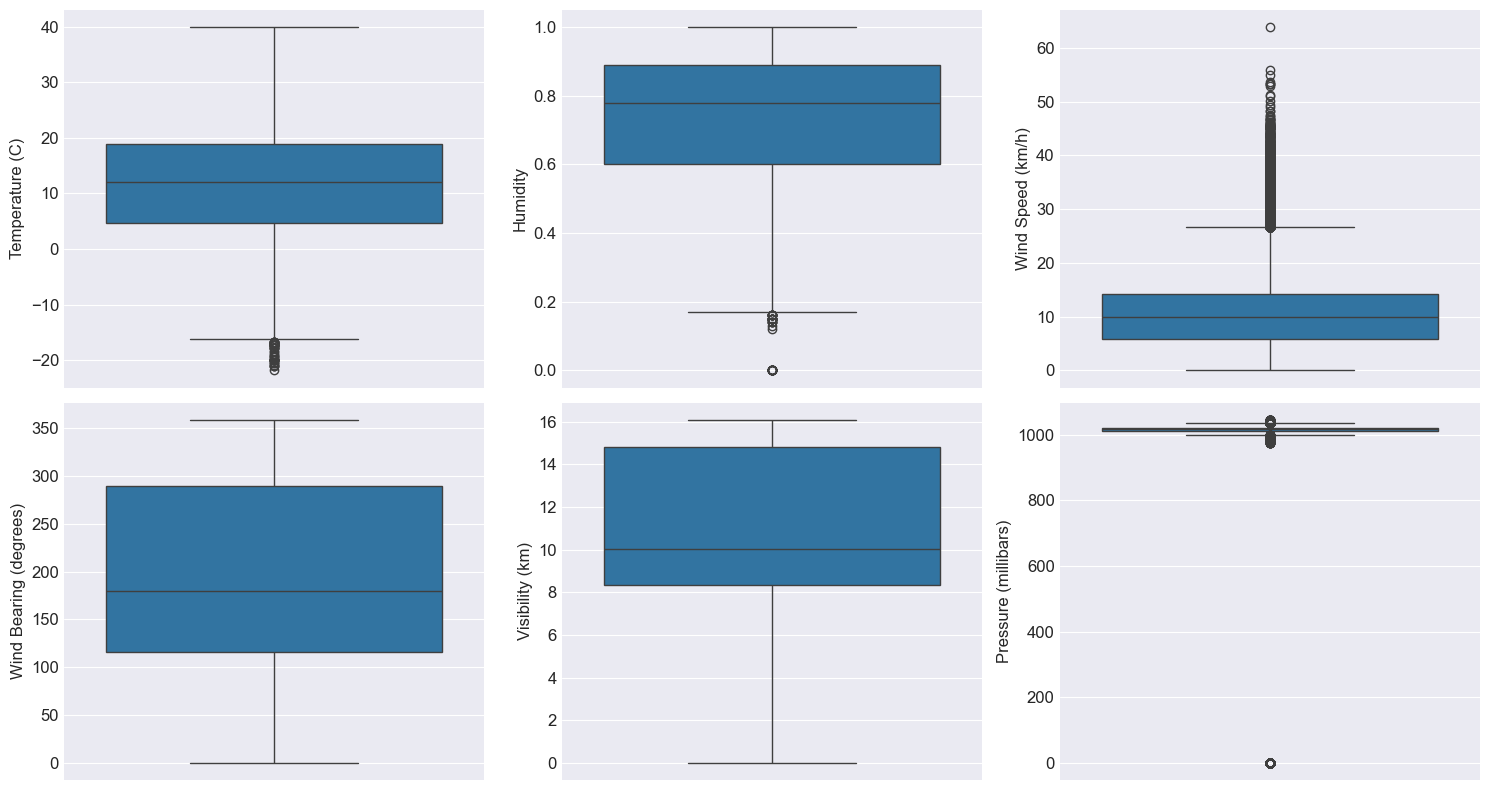

In [8]:
# num_cols = ['Temperature (C)',
#         'Humidity', 'Wind Speed (km/h)',
#        'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover']

fig, axes = plt.subplots(2,3 ,figsize = (15,8))
nbin = 100
axes = axes.ravel()
for count,col in enumerate(num_cols):
    ax = axes[count]
    sns.boxplot(data = data_df, y = col, ax = ax)
plt.tight_layout()

In [9]:
data_df['Loud Cover'].value_counts()

Loud Cover
0.0    96453
Name: count, dtype: int64

In [10]:
data_df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)',
       'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover',
       'Pressure (millibars)', 'Daily Summary', 'datetime'],
      dtype='object')

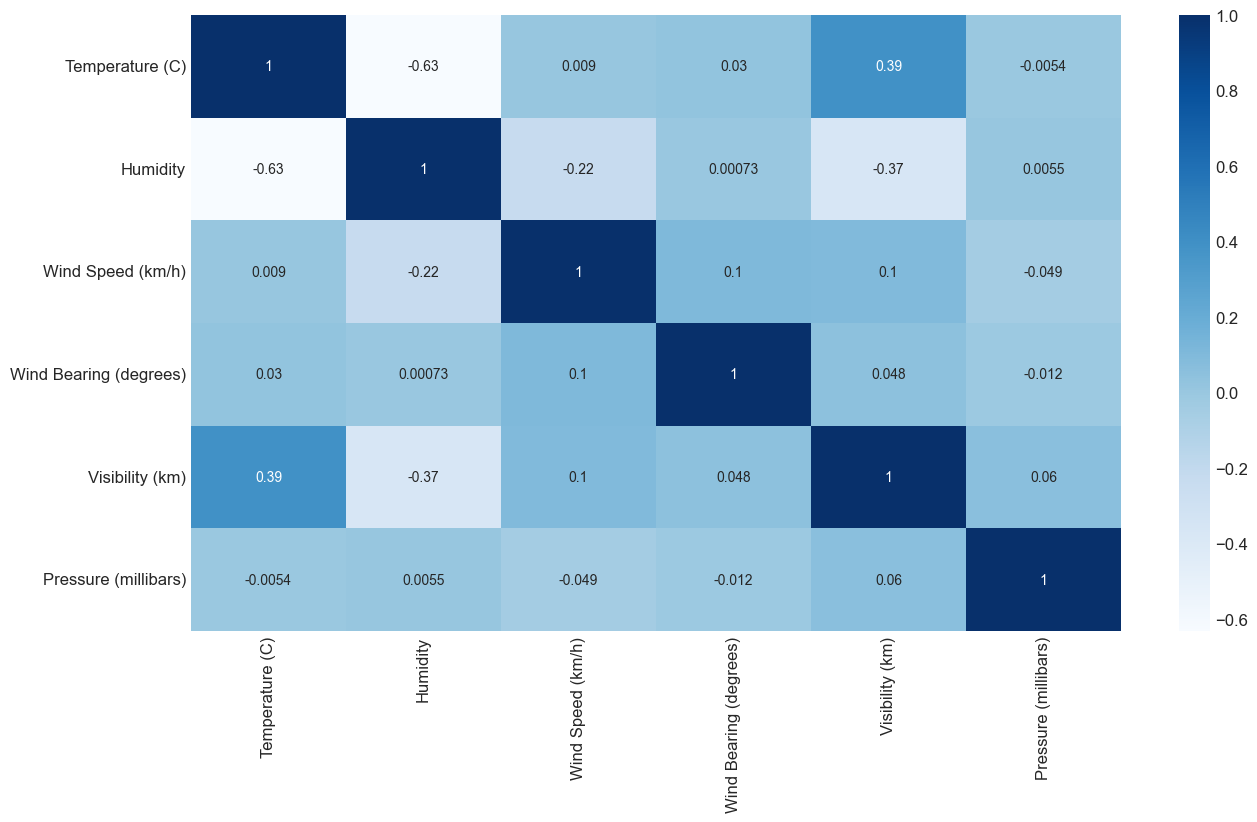

In [11]:
sns.heatmap(data_df[num_cols].corr(), annot = True, cmap = 'Blues');

In [12]:
temp_df = data_df[['datetime', 'Temperature (C)']]
temp_df = temp_df.sort_values('datetime', axis =0, ascending=True)
temp_df = temp_df.reset_index(drop=True)
temp_df = temp_df.rename({'Temperature (C)': 'temp'}, axis =1)
temp_df.head()

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333


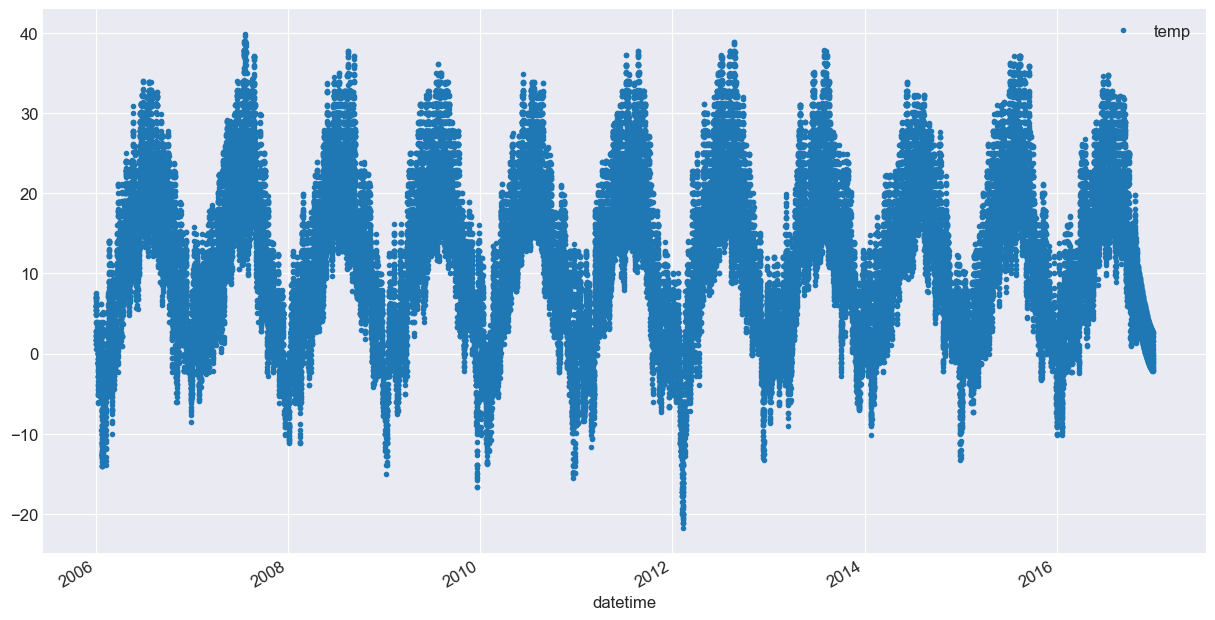

In [13]:
ax = temp_df.plot(x = 'datetime', y='temp', style = '.');


In [14]:
h_units = 100 # hidden layers No. of neurons
input_shape = (1,10000) # inputs 

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                   activation='tanh'
                                   ))
model.add(tf.keras.layers.Dense(1,
                                   activation='linear',
                                   
                                   ))

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 100)                 │       1,010,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,010,201 (3.85 MB)

 Trainable params: 1,010,201 (3.85 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
for ax in model.get_weights():
    print(ax.shape)
print('\n')
print(f'Wax = {model.get_weights()[0].shape}')
print(f'Waa = {model.get_weights()[1].shape}')
print(f'ba = {model.get_weights()[2].shape}')
print(f'Way = {model.get_weights()[3].shape}')
print(f'by = {model.get_weights()[4].shape}')

(10000, 100)
(100, 100)
(100,)
(100, 1)
(1,)


Wax = (10000, 100)
Waa = (100, 100)
ba = (100,)
Way = (100, 1)
by = (1,)


In [16]:
temp_df

,datetime,temp
0,2005-12-31 23:00:00+00:00,0.577778
1,2006-01-01 00:00:00+00:00,1.161111
2,2006-01-01 01:00:00+00:00,1.666667
3,2006-01-01 02:00:00+00:00,1.711111
4,2006-01-01 03:00:00+00:00,1.183333
...,...,...
96448,2016-12-31 18:00:00+00:00,0.488889
96449,2016-12-31 19:00:00+00:00,0.072222
96450,2016-12-31 20:00:00+00:00,-0.233333
96451,2016-12-31 21:00:00+00:00,-0.472222


In [17]:
time_step = 24
temp_df.shape[0]/time_step

y_idx = np.arange(time_step, temp_df.shape[0], time_step)
y_idx

array([   24,    48,    72, ..., 96384, 96408, 96432])

In [18]:
y_df = temp_df.iloc[y_idx]
y_df.head()

,datetime,temp
24,2006-01-01 23:00:00+00:00,5.422222
48,2006-01-02 23:00:00+00:00,1.694444
72,2006-01-03 23:00:00+00:00,2.200000
96,2006-01-04 23:00:00+00:00,1.666667
120,2006-01-05 23:00:00+00:00,1.805556


In [19]:
y_df.shape

(4018, 2)

In [20]:
X_df = temp_df.iloc[range(len(y_df) * time_step)]
X_df.shape

(96432, 2)

In [21]:
# Reshape to match number of e=rows in y_df

X = np.reshape(X_df['temp'].values, (y_df.shape[0], time_step))
X.shape, y_df.shape

((4018, 24), (4018, 2))

In [22]:
# remove last column
X = X[:, :23]
X.shape

(4018, 23)

In [23]:
X[0], y_df.head(1)

(array([0.57777778, 1.16111111, 1.66666667, 1.71111111, 1.18333333,
        1.20555556, 2.22222222, 2.07222222, 2.2       , 2.73333333,
        2.78888889, 3.82222222, 4.91111111, 6.20555556, 7.43888889,
        6.95      , 5.97222222, 5.90555556, 4.95555556, 5.47222222,
        5.97222222, 4.93333333, 5.47222222]),
                     datetime      temp
 24 2006-01-01 23:00:00+00:00  5.422222)

[samples, timesteps, features]

In [25]:
X = np.reshape(X, (X.shape[0], X.shape[1], 1))
X.shape

(4018, 23, 1)

In [26]:
split = int(y_df.shape[0] * (1 - TEST_SIZE))
split

3214

In [27]:
X_train = X[:split]
X_test = X[split:]
y_train = y_df['temp'].values[:split]
y_test = y_df['temp'].values[split:]

In [28]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3214, 23, 1), (804, 23, 1), (3214,), (804,))

In [29]:
h_units = 256 # hidden layers No. of neurons
input_shape = (time_step - 1,1) # inputs  (time_Step, feature )
initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Input(shape=input_shape))
model.add(tf.keras.layers.SimpleRNN(units = h_units,
                                    kernel_initializer= initializer,
                                       activation='tanh'
                                   ))
model.add(tf.keras.layers.Dense(1,
                                   activation='linear',
                                   
                                   ))

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 256)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,305 (259.00 KB)

 Trainable params: 66,305 (259.00 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer = 'adam', # optimisation, loss calculation 
             loss = 'mean_squared_error',
              metrics = [tf.keras.metrics.RootMeanSquaredError(name='RMSE', dtype=None)]
             )
history = model.fit(x = X_train, y = y_train, 
                    validation_data = [X_test, y_test],
                    batch_size = BATCH_SIZE,
                    verbose = 1,
                    epochs =EPOCHS
                   )

Epoch 1/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - RMSE: 5.0627 - loss: 30.6430 - val_RMSE: 1.0026 - val_loss: 1.0052
Epoch 2/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - RMSE: 1.3337 - loss: 1.7823 - val_RMSE: 0.9839 - val_loss: 0.9681
Epoch 3/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - RMSE: 1.1651 - loss: 1.3607 - val_RMSE: 0.9367 - val_loss: 0.8773
Epoch 4/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - RMSE: 1.1339 - loss: 1.2888 - val_RMSE: 0.8439 - val_loss: 0.7121
Epoch 5/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - RMSE: 1.0880 - loss: 1.1861 - val_RMSE: 0.8253 - val_loss: 0.6812
Epoch 6/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - RMSE: 1.0672 - loss: 1.1408 - val_RMSE: 0.8175 - val_loss: 0.6683
Epoch 7/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - RMSE: 1.0590 - loss: 1.1233 - val_RMSE: 0.8145 - val_loss: 0.6634
Epoch 8/30
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - RMSE: 1.0596 - loss: 1.1247 - val_RMSE: 0.8213 - val_loss: 0.6745
Epoch 9/30
101/101 ━━━━━━━━━━━━

In [31]:
loss_df = pd.DataFrame(history.history)

In [42]:
loss_df

,RMSE,loss,val_RMSE,val_loss
0,3.153152,9.942367,1.002574,1.005154
1,1.254852,1.574655,0.983939,0.968136
2,1.120530,1.255589,0.936657,0.877326
3,1.088231,1.184246,0.843854,0.712089
4,1.053465,1.109789,0.825324,0.681160
5,1.037226,1.075838,0.817495,0.668298
6,1.031953,1.064927,0.814514,0.663432
7,1.029633,1.060145,0.821253,0.674457
8,1.021819,1.044113,0.820273,0.672848
9,1.027200,1.055140,0.837048,0.700650


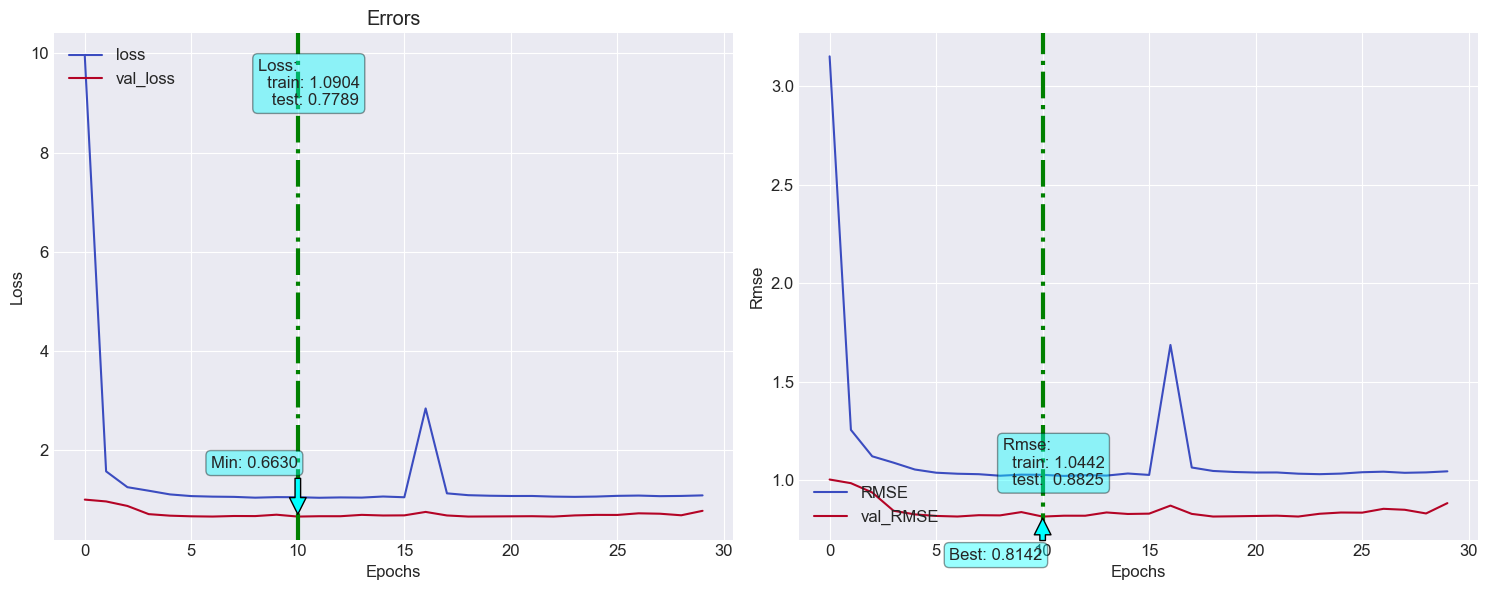

In [32]:
fn_plot_tf_hist(loss_df)

In [38]:
y_tr_pred = model.predict(X_train)
y_ts_pred = model.predict(X_test)

y_pred = np.append(y_tr_pred, y_ts_pred)
res_df = y_df.copy()
res_df['pred'] = y_pred
res_df.head()

101/101 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,datetime,temp,pred
24,2006-01-01 23:00:00+00:00,5.422222,5.288267
48,2006-01-02 23:00:00+00:00,1.694444,1.815911
72,2006-01-03 23:00:00+00:00,2.200000,2.182149
96,2006-01-04 23:00:00+00:00,1.666667,2.106804
120,2006-01-05 23:00:00+00:00,1.805556,2.437944


<Axes: xlabel='datetime'>

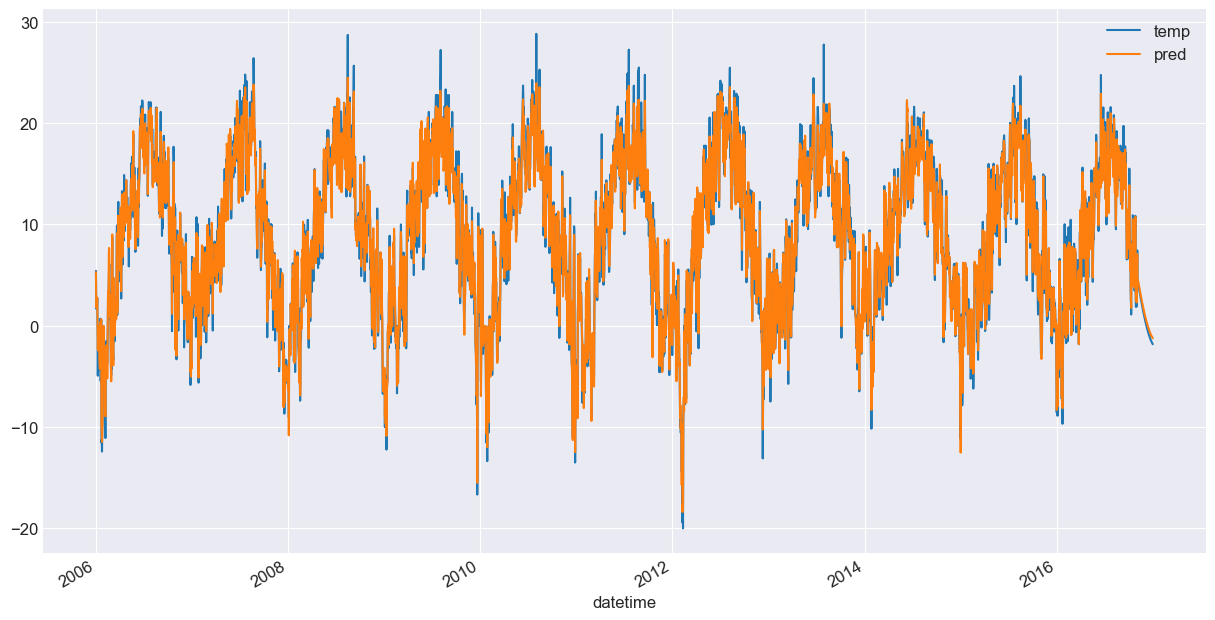

In [40]:
res_df.plot(x = 'datetime', y=['temp', 'pred'])